In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

In [31]:
file_path = '../Dataset Creation/synthetic_heart_attack_data_balanced.csv'
dataset = pd.read_csv(file_path)

In [32]:
X = dataset.drop(columns=['Heart_Attack_Prediction'])
y = dataset['Heart_Attack_Prediction']

In [33]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    tf.keras.layers.Dropout(0.3),  # Dropout layer after the input layer (30% dropout rate)
    
    tf.keras.layers.Dense(8, activation='relu'),  # Hidden layer
    tf.keras.layers.Dropout(0.3),  # Dropout layer after the hidden layer (30% dropout rate)
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer (Binary Classification)
])

In [46]:
adam = Adam(lr=0.001)

In [47]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [49]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
1250/1250 [==============================] - 1s 706us/step - loss: 0.1717 - accuracy: 0.9396 - val_loss: 0.0347 - val_accuracy: 0.9881
Epoch 2/50
1250/1250 [==============================] - 1s 652us/step - loss: 0.0583 - accuracy: 0.9824 - val_loss: 0.0316 - val_accuracy: 0.9888
Epoch 3/50
1250/1250 [==============================] - 1s 660us/step - loss: 0.0492 - accuracy: 0.9847 - val_loss: 0.0326 - val_accuracy: 0.9885
Epoch 4/50
1250/1250 [==============================] - 1s 669us/step - loss: 0.0469 - accuracy: 0.9850 - val_loss: 0.0319 - val_accuracy: 0.9888
Epoch 5/50
1250/1250 [==============================] - 1s 657us/step - loss: 0.0445 - accuracy: 0.9859 - val_loss: 0.0314 - val_accuracy: 0.9887
Epoch 6/50
1250/1250 [==============================] - 1s 670us/step - loss: 0.0448 - accuracy: 0.9852 - val_loss: 0.0313 - val_accuracy: 0.9886
Epoch 7/50
1250/1250 [==============================] - 1s 661us/step - loss: 0.0438 - accuracy: 0.9847 - val_loss: 0.0314 -

KeyboardInterrupt: 

In [40]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

313/313 [==============================] - 0s 485us/step - loss: 0.0317 - accuracy: 0.9888
Test Loss: 0.0317, Test Accuracy: 0.9888


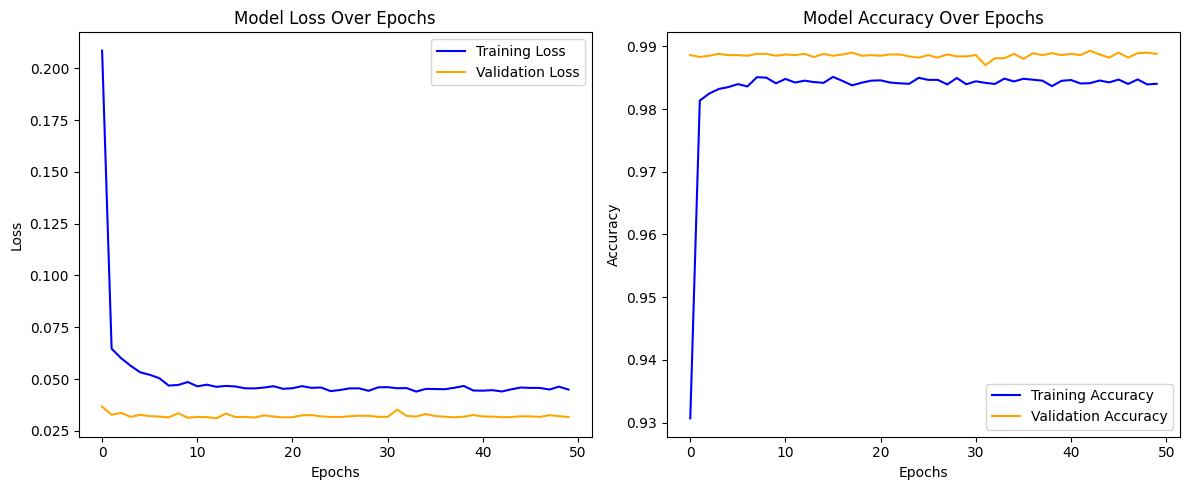

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import classification_report

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Generate classification report
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

313/313 [==============================] - 0s 393us/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5047
           1       0.99      0.98      0.99      4953

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [43]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
tflite_model_path = "prediction.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to {tflite_model_path}")

INFO:tensorflow:Assets written to: C:\Users\vivek\AppData\Local\Temp\tmp8qcb7cnl\assets


INFO:tensorflow:Assets written to: C:\Users\vivek\AppData\Local\Temp\tmp8qcb7cnl\assets


TensorFlow Lite model saved to prediction.tflite


In [44]:
with open("prediction.tflite", "rb") as f:
    tflite_model = f.read()

# Convert to a C-style byte array
c_array = ', '.join(f'0x{b:02x}' for b in tflite_model)
with open("model_data.h", "w") as f:
    f.write(f"const unsigned char tflite_model[] = {{ {c_array} }};\n")
    f.write(f"const unsigned int tflite_model_len = {len(tflite_model)};")